In [1]:
import numpy as np
import matplotlib.pyplot as plt
from diskmodels import profilecirc
from diskfit import likelihood, utils
from scipy.optimize import minimize
import emcee

z = 0.04573
cont = np.array([-2.38021710e-25, 2.19637816e+00, 1.72525087e-16])
sub = 5e-18

#### Functions

In [2]:
def power_law(wl, A, k, C):
    return A*(wl/(1+z))**k+C

def model_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, w, y, yerr, lines, linesbroad, fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    ampsbroad = [params['broadHalphaflux']]
    lineprofsbroad = utils.build_line_profiles(x,linesbroad,params['broadwidth'])   
    broadmodel = lineprofsbroad[0] * ampsbroad[0]
    for line,amp in zip(lineprofsbroad[1:],ampsbroad[1:]):
        narrowmodel1+=line*amp 
    model = np.sum((diskout,narrowmodel,broadmodel),axis=0)
    return model

def plot_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, w, y, yerr, lines, linesbroad,fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    ampsbroad = [params['broadHalphaflux']]
    lineprofsbroad = utils.build_line_profiles(x,linesbroad,params['broadwidth'])   
    broadmodel = lineprofsbroad[0] * ampsbroad[0]
    for line,amp in zip(lineprofsbroad[1:],ampsbroad[1:]):
        narrowmodel1+=line*amp 
    model = np.sum((diskout,narrowmodel,broadmodel),axis=0)

    return diskout,narrowmodel,broadmodel

class log_prior(object):
    def __init__(self, mins, maxes):
        self.mins = mins
        self.maxes = maxes
    def __call__(self, theta): 
        if np.any(theta<self.mins) or np.any(theta>self.maxes): 
            return -np.inf
        return 0.0 

class logprob_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(object):
    def __init__(self, x, y, yerr, lines, linesbroad, fixed, fitted, mins, maxes): 
        self.x = x
        self.y = y
        self.yerr = yerr
        self.lines = lines
        self.linesbroad = linesbroad
        self.fixed = fixed
        self.fitted = fitted
        self.mins = mins
        self.maxes = maxes
        self.log_prior = log_prior(self.mins, self.maxes)
    def __call__(self,theta):
        lp = self.log_prior(theta)
        like = loglikelihood_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.linesbroad,self.fixed, self.fitted)
        if np.any(np.isnan(like)):
            #return np.full(len(like),1e10+lp)
            return -np.inf   
        #print(like,lp)
        return like+lp 
    def test(self,theta):
        modelout = model_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.linesbroad, self.fixed, self.fitted) 
        return modelout 
    def plot(self,theta):
        diskout,narrowout, broadout = plot_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.linesbroad, self.fixed, self.fitted) 
        return diskout,narrowout,broadout

def loglikelihood_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, w, y, yerr, lines, linesbroad,fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    ampsbroad = [params['broadHalphaflux']]
    lineprofsbroad = utils.build_line_profiles(x,linesbroad,params['broadwidth'])   
    broadmodel = lineprofsbroad[0] * ampsbroad[0]
    for line,amp in zip(lineprofsbroad[1:],ampsbroad[1:]):
        narrowmodel1+=line*amp 
    model = np.sum((diskout,narrowmodel,broadmodel),axis=0) 
    sigma2 = yerr**2  
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

#### Spec

In [3]:
fn = 'spec.txt'
wl, flux = np.loadtxt(fn, unpack=True)
flux -= power_law(wl, *cont) + sub
flux *= 1e17

olambda = 6563
wavemin = 6100
wavemax = 7000
wave = wl/(1+z)
indwave = np.argwhere((wave>wavemin)&(wave<wavemax)&~np.isnan(flux))[:,0]
wl = np.asarray(wl[indwave],dtype=np.float64)
fluxerr = np.ones(flux.shape)*np.median(np.abs(flux[1:]-flux[:-1]))
flux = flux[indwave]
fluxerr = 3*fluxerr[indwave]
npix = wl.shape[0]

In [4]:
# Integration, units, normalization
maxstep = 400 # Maximum number of integration steps (integer)
nstep = 100 # integration steps (integer, </= 400)
relativistic = 'y' #  include relativistic effects? (y/n) [y]
normalization = 'max' # profile normalization scheme (max/flux/none) [max]

# Circular disk size and emission properties
q1 = 1.9 #inner emissivity powerlaw index
q2 = 1.9 #outer emissivity powerlaw index
xib = 0.6 #power-law index break radius (XIB=0 causes Q=Q2 throughout)

# Wind properties
t0 = 1e-3   # optical depth normalization (0=no wind)
eta = 1. #optical depth power-law index
anglam = 2.1 #wind opening angle (degrees)
version = 'f' #formula for escape probability (f=Flohic, m=Murray)

# Spiral arms
amp = 1e-12 #contrast of spiral arm (0=no arms)
narms = 1 #number of arms (integer)
aobs = 95 #spiral orientation (degrees, +ve=outer, -ve=inner)
pitch = -20 #pitch angle of spiral pattern (+ve=leading, -ve=trailing)
width = 40 #angular width of arm (degrees)
xispin = 0 #inner spiral arm radius radius (GM/c^2, 0=XI1)
xispout = 0 #outer spiral arm radius radius (GM/c^2, 0=XI2)

#Narrow lines
narrowwidth = 1.7 # Width of component 1 of broad line in Angstroms
narrowwidth2 = 0.9 # Width of component 2 of broad line in Angstroms
narrowfrac = 0.2 #Amplitude fraction the two narrow line components

broadwidth = 80
broadHalphaflux = 4

In [5]:
angimin, angimax = -360, 360
xi1min, xi1max = 50, 10000
xi2min, xi2max = 100, 10000
broadmin, broadmax = 0, 2000
ampmin, ampmax = -1e-12, 5.0
pitchmin, pitchmax = -60, 60
aobsmin, aobsmax = -720, 360*3
broadwidthmin, broadwidthmax = 20, 500
broadHalphafluxmin, broadHalphafluxmax = 0.0, 300
narrowwidthmin, narrowwidthmax = 0.1, 15.0
narrowwidth2min, narrowwidth2max = 0.1, 12.0
narrowfracmin, narrowfracmax = 0.1, 5.0
anglammin, anglammax = 2.0, 40
t0min, t0max = 1e-10, 1e2
etamin, etamax = -1.5, 1.5
Halphafluxmin, Halphafluxmax = 0, 30
NIIbfluxmin, NIIbfluxmax = 0.0, 8
SIIbfluxmin, SIIbfluxmax = 0.0, 300
diskfluxmin, diskfluxmax = 1, 500

diskmins = [
xi1min,xi2min,broadmin,angimin,narrowfracmin,narrowwidthmin,narrowwidth2min,broadwidthmin,broadHalphafluxmin,anglammin,t0min,etamin,Halphafluxmin,NIIbfluxmin,diskfluxmin]
diskmax = [
xi1max,xi2max,broadmax,angimax,narrowfracmax,narrowwidthmax,narrowwidth2max,broadwidthmax,broadHalphafluxmax,anglammax,t0max,etamax,Halphafluxmax,NIIbfluxmax,diskfluxmax]

In [6]:
NIIa = 6549.86
Halpha = 6564.614
NIIb = 6585.27
SIIa = 6718.29
SIIb = 6732.68
lines = [Halpha,NIIa,NIIb,SIIa,SIIb]
linesbroad = [Halpha]
NIIb_NIIa = 2.95
SIIb_SIIa = 1.3
ratios = [NIIb_NIIa,SIIb_SIIa]
Halphaflux = 0.5
NIIbflux = 0.3
diskflux = 5
SIIbflux = 0

In [7]:
angi = 60 #disk inclination angle (degrees)
xi1 = 1000 #inner disk radius (GM/c^2)
xi2 = 3000 #outer disk radius (multiple of xi1)
broad = 600 #broadening parameter (km/s)

fitted_labels = ['xi1','xi2','broad','angi','narrowfrac','narrowwidth','narrowwidth2','broadwidth','broadHalphaflux','anglam','t0','eta','Halphaflux','NIIbflux','diskflux']
initial = [xi1,xi2,broad,angi,narrowfrac,narrowwidth,narrowwidth2,broadwidth,broadHalphaflux,anglam,t0,eta,Halphaflux,NIIbflux,diskflux]
fitted = dict(zip(fitted_labels,initial))

fixed_labels = ['z','ratios','q1','q2','xib','maxstep','version','amp','narms','aobs','pitch','width','xispin','xispout','nstep','relativistic','olambda','npix','SIIbflux']
fixed_values = [z,ratios,q1,q2,xib,maxstep,version,amp,narms,aobs,pitch,width,xispin,xispout,nstep,relativistic,olambda,npix,SIIbflux]
fixed = dict(zip(fixed_labels,fixed_values))

In [8]:
modelguess = model_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(initial, wl, flux, fluxerr, lines, linesbroad, fixed, fitted)
disk,narrowlines,broadlines = plot_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(initial, wl, flux, fluxerr, lines, linesbroad, fixed, fitted)

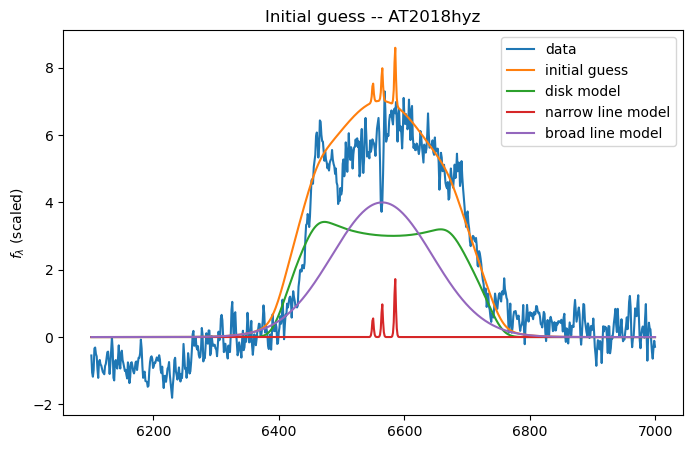

In [9]:
plt.figure(figsize=(8,5))
plt.plot(wl/(1+fixed['z']),flux,label='data')
plt.plot(wl/(1+fixed['z']),modelguess,label='initial guess')
plt.plot(wl/(1+fixed['z']),disk,label='disk model')
plt.plot(wl/(1+fixed['z']),narrowlines,label='narrow line model')
plt.plot(wl/(1+fixed['z']),broadlines,label='broad line model')
plt.ylabel(r'f$_\lambda$ ' + ' (10$^{17}\cdot$erg/s/cm$^2$/Hz)'); plt.ylabel('$f_{\lambda}$ (scaled)')
plt.title('Initial guess -- AT2018hyz')
plt.legend()
plt.show()

In [10]:
lp = logprob_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(wl, flux, fluxerr, lines, linesbroad, fixed, fitted, diskmins, diskmax)

In [11]:
nll = lambda *args: -lp(*args)
soln = minimize(nll, initial, method='Nelder-Mead')
modelfit = lp.test(soln.x)

print('Best-fit parameter values:', soln.x)

Best-fit parameter values: [ 7.89344770e+02  9.77928233e+02  8.74322037e+02  3.51288178e+01
  2.38714521e-01  2.95218359e+00  1.90764349e+00  9.07773619e+01
  3.34934105e+00  2.00000819e+00  1.21957299e-03 -9.26463088e-01
  4.11499388e-06  3.58859009e-01  9.38541741e+00]


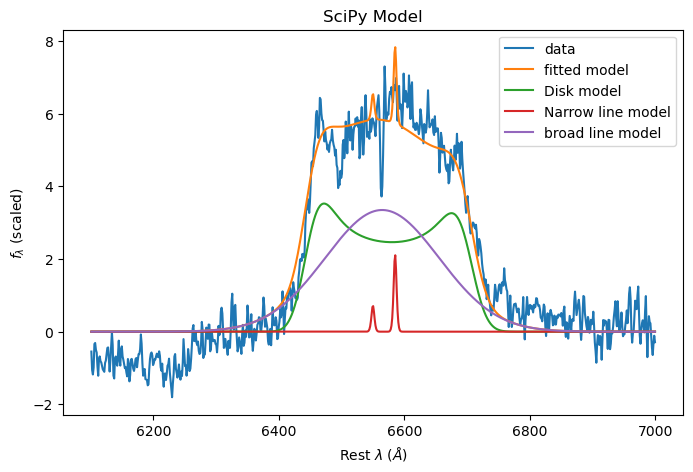

In [12]:
disk,narrowlines,broadlines = lp.plot(soln.x)
plt.figure(figsize=(8,5))
plt.plot(wl/(1+fixed['z']),flux,label='data')
plt.plot(wl/(1+fixed['z']),modelfit,label='fitted model')
plt.plot(wl/(1+fixed['z']),disk,label='Disk model')
plt.plot(wl/(1+fixed['z']),narrowlines,label='Narrow line model')
plt.plot(wl/(1+fixed['z']),broadlines,label='broad line model')
plt.xlabel('Rest $\lambda$ ($\AA$)'); plt.ylabel('$f_{\lambda}$ (scaled)')
plt.title('SciPy Model'); plt.legend(); plt.show()

In [14]:
pos = soln.x + 5e-1 * soln.x * np.random.randn(50, soln.x.shape[0])
nwalkers, ndim = pos.shape; print(pos.shape)
filename ='emcee-2018hyz-E3.h5'
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lp, args=(), backend=backend
    )
sampler.run_mcmc(pos, 2500, progress=True)

(50, 15)


  0%|          | 6/2500 [01:21<9:31:35, 13.75s/it]/tmp/ipykernel_2944692/857628735.py:118: RuntimeWarning: overflow encountered in square
  return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
  0%|          | 11/2500 [02:31<9:35:04, 13.86s/it]/tmp/ipykernel_2944692/857628735.py:118: RuntimeWarning: overflow encountered in true_divide
  return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
100%|██████████| 2500/2500 [10:48:34<00:00, 15.57s/it] 


State([[ 3.63513242e+02  8.78526641e+02  2.79725435e+02  3.13869962e+01
   1.46096695e+00  2.67713338e+00  1.55114328e+00  8.37907785e+01
   1.93074772e+00  8.54853126e+00  6.99127619e-03 -1.26113915e+00
   1.42535836e-05  2.97597470e-02  2.79618545e+01]
 [ 5.51394336e+02  7.95972240e+02  3.21383240e+02  3.05397768e+01
   1.26922020e+00  3.76405396e+00  4.83383824e+00  9.97097618e+01
   3.24029909e+00  5.97879386e+00  1.31138924e-03 -5.13906665e-01
   3.61598006e-06  1.56568342e-01  1.95009646e+01]
 [ 6.68150624e+02  1.16431412e+03  6.10048597e+02  3.62532006e+01
   3.99866551e-01  7.57787450e+00  6.89053280e+00  1.07335318e+02
   2.18588718e+00  1.00504052e+01  2.15876853e-03  3.58609069e-01
   8.24140559e-06  1.59053147e-01  2.49730071e+01]
 [ 3.98031908e+02  1.19135503e+03  3.49186342e+02  3.41087495e+01
   1.27655182e+00  1.43297727e+01  1.90197334e+00  1.23041836e+02
   1.10525806e+00  1.15858475e+01  4.19065880e-03 -1.31099455e+00
   1.53039387e-05  2.90438799e-01  1.61064477e+01

In [19]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lp, args=(), backend=emcee.backends.HDFBackend('emcee-2018hyz-E3.h5'))
sampler.run_mcmc(None, 1000, progress=True)

  2%|▏         | 23/1000 [05:40<3:59:53, 14.73s/it]/tmp/ipykernel_2944692/857628735.py:118: RuntimeWarning: overflow encountered in square
  return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
 10%|▉         | 95/1000 [23:30<3:43:50, 14.84s/it]/tmp/ipykernel_2944692/857628735.py:118: RuntimeWarning: overflow encountered in true_divide
  return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
 18%|█▊        | 175/1000 [43:18<3:24:52, 14.90s/it]Traceback (most recent call last):
  File "/home/at4206/.conda/envs/Diskfit/lib/python3.10/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_2944692/857628735.py", line 80, in __call__
    like = loglikelihood_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.linesbroad,self.fixed, self.fitted)
  File "/tmp/ipykernel_2944692/857628735.py", line 98, in loglikelihood_circ_fixeddoublet_freeamplitudes

emcee: Exception while calling your likelihood function:
  params: [ 4.77809205e+02  8.53923619e+02  3.13408223e+02  3.08474216e+01
  1.09822482e+00  8.66981681e+00 -3.61834600e-01  8.31559124e+01
  2.08134749e+00  8.75711811e+00  4.02091164e-03 -1.65075453e+00
  3.48323698e-05  3.15218631e-01  2.85286252e+01]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 